In [1]:
import geopandas as gpd
import networkx as nx
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy import sparse

In [2]:
sample_num = 2000

### Graph Construction —— Population Flow

In [3]:
# 确认节点数量
bs_gpd = gpd.read_file('../../data/basestation-gis/basestation_aggregation.shp')
bs_gpd = bs_gpd.iloc[:sample_num:, ::]
bs_num = bs_gpd.shape[0]

# 构造图节点
nodes_list = list(range(bs_num))
G1 = nx.Graph()
G1.add_nodes_from(nodes_list)

# 读取邻接矩阵adjacent
# 以工作日(周一)的早高峰时段为例
adj = pd.read_csv('../../data/adj/adj_20151109_0002.csv')
adj = adj.iloc[:, 1:].values
adj = adj[:sample_num:, :sample_num:]
adj = adj + adj.T
for i in range(sample_num): adj[i, i] = 0
    
# for i in range(bs_num):
#     if (adj[i]==0).all():
#         adj[i, :] = 0.0001
#         adj[:, i] = 0.0001
        
for i in tqdm(range(bs_num)):
    for j in range(bs_num):
        tmp = adj[i, j]
        if tmp>0: G1.add_edge(i, j, weight=tmp)

100%|██████████| 2000/2000 [00:03<00:00, 564.20it/s]


### Graph Construction —— Geographic Reachability

### Feature Construction —— Equality Contribution

In [4]:
feature = pd.read_csv('../../data/features/features_wf_new.csv')
feature = feature.iloc[:, 1::].values

In [5]:
feature = feature[:sample_num:, :]

### Node Embedding —— Karate Club

In [6]:
import networkx as nx
import karateclub
from tkinter import _flatten

In [20]:
model = karateclub.AE(dimensions=15)
model.fit(graph=G1, X=sparse.coo_matrix(feature))
embeding = model.get_embedding()
print(embeding.shape)

(500, 30)


In [21]:
model = karateclub.MUSAE(dimensions=15)
model.fit(graph=G1, X=sparse.coo_matrix(feature))
embeding = model.get_embedding()
print(embeding.shape)

(500, 60)


In [22]:
model = karateclub.SINE(dimensions=15)
model.fit(graph=G1, X=sparse.coo_matrix(feature))
embeding = model.get_embedding()
print(embeding.shape)

(500, 15)


In [23]:
model = karateclub.BANE(dimensions=15)
model.fit(graph=G1, X=sparse.coo_matrix(feature))
embeding = model.get_embedding()
print(embeding.shape)

(500, 15)


In [25]:
model = karateclub.TENE(dimensions=15)
model.fit(graph=G1, T=sparse.coo_matrix(feature))
embeding = model.get_embedding()
print(embeding.shape)

(500, 30)


In [27]:
model = karateclub.FSCNMF(dimensions=15)
model.fit(graph=G1, X=sparse.coo_matrix(feature))
embeding = model.get_embedding()
print(embeding.shape)

(500, 30)


In [28]:
model = karateclub.ASNE(dimensions=15)
model.fit(graph=G1, X=sparse.coo_matrix(feature))
embeding = model.get_embedding()
print(embeding.shape)

(500, 15)


### Node Embedding —— Graph Convolutional Network

In [6]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
import time
import numpy as np
from dgl.data import citation_graph as citegrh
import networkx as nx
import community

gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

Using backend: pytorch


In [7]:
A = th.from_numpy(adj).float()
d = th.from_numpy(np.sum(adj, axis=1).reshape((-1, 1))).float()
mm = np.sum(adj)
B = A - th.mm(d, d.T)/mm
B_norm = B/mm
DG1 = dgl.DGLGraph()
DG1.from_networkx(G1)
features = th.from_numpy(feature).float()

# D_ = th.diag(th.pow(d.view(-1), -1/2))
# A_norm = th.mm(th.mm(D_, A), D_)

k = 15
in_dim = features.size()[1]
hid_dim = int(np.sqrt(in_dim*k))

**在GCN-output之后，添加了ReLU**

In [12]:
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata['h']
            return self.linear(h)
        
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = GCNLayer(in_dim, hid_dim)
        self.layer2 = GCNLayer(hid_dim, k)

    def forward(self, g, features):
        x = F.relu(self.layer1(g, features))
        x = F.relu(self.layer2(g, x))
        return x
net = Net()
print(net)

Net(
  (layer1): GCNLayer(
    (linear): Linear(in_features=20, out_features=17, bias=True)
  )
  (layer2): GCNLayer(
    (linear): Linear(in_features=17, out_features=15, bias=True)
  )
)


In [13]:
optimizer = th.optim.Adam(net.parameters(), lr=2e-2)
# optimizer = th.optim.Adam(net.parameters(), lr=3e-2, weight_decay=0, betas=(0.5, 0.999), eps=1e-08)
epoch_num = 3000
dur_loss = []
dur_modu = []
dur = []

net.train()

for epoch in range(epoch_num):
    if epoch >=0:
        t0 = time.time()
    
    # net.train()
    Z = net(DG1, features)
    # Z_norm = th.div(Z, Z.sum(axis=1).view(-1, 1))
    U = F.softmax(Z, dim=1).T
    L = th.mm(th.mm(U, B_norm), U.T)
    L = F.softmax(L, dim=0)
    # L = F.softmax(th.div(L, L.sum(axis=0)), dim=0)
    # loss = -1*th.trace(L)/mm
    # loss = th.trace(-1*th.log_softmax(L, dim=0))
    loss = th.trace(-th.log(L))
    dur_loss.append(loss)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch >=0:
        dur.append(time.time() - t0)

    partition = dict(zip(list(G1.nodes()), th.argmax(U, axis=0).tolist())) 
    dur_modu.append(community.modularity(partition, G1, weight='weight'))
    if epoch%20 == 0:
        print("Epoch {:05d} | Loss {:.4f} | Modularity {:.4f} | Time(s) {:.4f}".format(epoch, loss.item(), dur_modu[-1], np.mean(dur)))

Epoch 00000 | Loss 40.6156 | Modularity 0.0001 | Time(s) 0.0361
Epoch 00020 | Loss 40.6067 | Modularity 0.0094 | Time(s) 0.0312
Epoch 00040 | Loss 40.6020 | Modularity 0.0219 | Time(s) 0.0307
Epoch 00060 | Loss 40.5836 | Modularity 0.0601 | Time(s) 0.0327
Epoch 00080 | Loss 40.5677 | Modularity 0.0786 | Time(s) 0.0319
Epoch 00100 | Loss 40.5567 | Modularity 0.0844 | Time(s) 0.0322
Epoch 00120 | Loss 40.5546 | Modularity 0.0720 | Time(s) 0.0315
Epoch 00140 | Loss 40.5504 | Modularity 0.0702 | Time(s) 0.0314
Epoch 00160 | Loss 40.5415 | Modularity 0.0970 | Time(s) 0.0305
Epoch 00180 | Loss 40.5387 | Modularity 0.0953 | Time(s) 0.0303
Epoch 00200 | Loss 40.5362 | Modularity 0.1017 | Time(s) 0.0300
Epoch 00220 | Loss 40.5342 | Modularity 0.1017 | Time(s) 0.0299
Epoch 00240 | Loss 40.5324 | Modularity 0.1016 | Time(s) 0.0304
Epoch 00260 | Loss 40.5307 | Modularity 0.1016 | Time(s) 0.0306
Epoch 00280 | Loss 40.5290 | Modularity 0.1026 | Time(s) 0.0312
Epoch 00300 | Loss 40.5273 | Modularity 

Epoch 02580 | Loss 40.6208 | Modularity 0.0000 | Time(s) 0.0333
Epoch 02600 | Loss 40.6208 | Modularity 0.0000 | Time(s) 0.0333
Epoch 02620 | Loss 40.6208 | Modularity 0.0000 | Time(s) 0.0333
Epoch 02640 | Loss 40.6208 | Modularity 0.0000 | Time(s) 0.0332
Epoch 02660 | Loss 40.6208 | Modularity 0.0000 | Time(s) 0.0332
Epoch 02680 | Loss 40.6208 | Modularity 0.0000 | Time(s) 0.0332
Epoch 02700 | Loss 40.6208 | Modularity 0.0000 | Time(s) 0.0332
Epoch 02720 | Loss 40.6208 | Modularity 0.0000 | Time(s) 0.0331
Epoch 02740 | Loss 40.6208 | Modularity 0.0000 | Time(s) 0.0331
Epoch 02760 | Loss 40.6208 | Modularity 0.0000 | Time(s) 0.0331
Epoch 02780 | Loss 40.6208 | Modularity 0.0000 | Time(s) 0.0331
Epoch 02800 | Loss 40.6208 | Modularity 0.0000 | Time(s) 0.0330
Epoch 02820 | Loss 40.6208 | Modularity 0.0000 | Time(s) 0.0330
Epoch 02840 | Loss 40.6208 | Modularity 0.0000 | Time(s) 0.0330
Epoch 02860 | Loss 40.6208 | Modularity 0.0000 | Time(s) 0.0330
Epoch 02880 | Loss 40.6208 | Modularity 

In [16]:
print(Z)
print(th.max(Z))

tensor([[5.6967, 2.2068, 0.0000,  ..., 1.9392, 0.0000, 0.0000],
        [2.4463, 3.8424, 0.0000,  ..., 2.6182, 0.0000, 0.0000],
        [0.0000, 0.5441, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.9094, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5964, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 1.1246, 0.0000,  ..., 0.0368, 0.0000, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor(183.0241, grad_fn=<MaxBackward1>)


In [18]:
th.max(F.softmax(Z, dim=1).T)

tensor(1., grad_fn=<MaxBackward1>)

**GCN+logmodularity+ReLU**

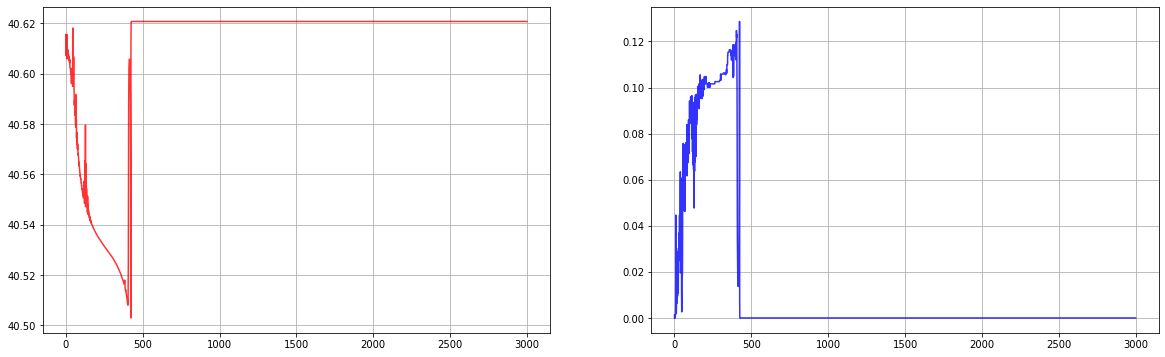

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(list(range(epoch_num)), dur_loss, color='red', label='loss', alpha=0.8)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(list(range(epoch_num)), dur_modu, color='blue', label='modularity', alpha=0.8)
plt.grid(True)
# plt.legend()

plt.show()

**GCN+logmodularity**

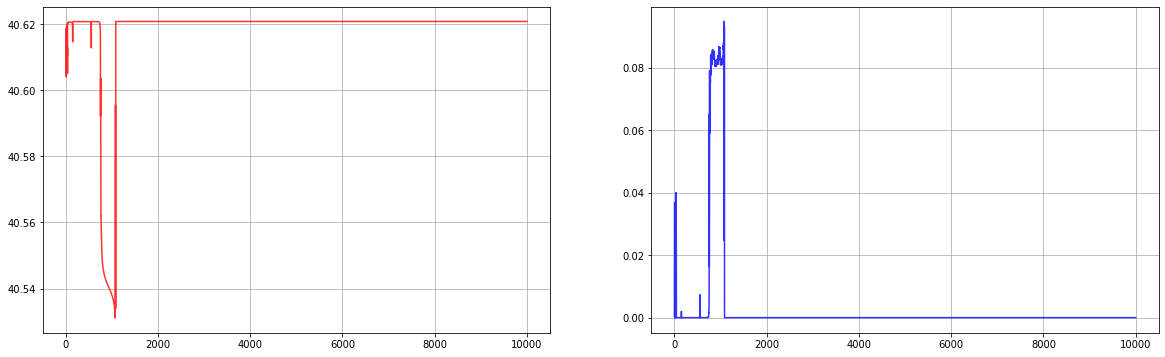

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(list(range(epoch_num)), dur_loss, color='red', label='loss', alpha=0.8)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(list(range(epoch_num)), dur_modu, color='blue', label='modularity', alpha=0.8)
plt.grid(True)
# plt.legend()

plt.show()

In [181]:
print(max(dur_modu))

0.33743910042380676
